In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import matplotlib.cm as cm
import arviz as az
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
import matplotlib.cm as cm
import regionmask
import cartopy.crs as ccrs
from sklearn.neural_network import MLPRegressor

In [2]:
nada=xr.open_dataset("/Users/kmarvel/Documents/GEDA_BAYES/DATA/nada_hd2_cl.nc")
nada=nada.where(nada.pdsi>-90)

In [3]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [4]:
class OBS():
    def __init__(self,data=None):
        if data is not None:
            self.data=data
        else:
            
            cru_t=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/cru_ts4.08.1901.2023.tmp.dat.nc")
            cru_p=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/cru_ts4.08.1901.2023.pre.dat.nc")
            cru_d=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/scPDSI.cru_ts4.08early1.1901.2023.cal_1901_23.bams.2024.GLOBAL.IGBP.WHC.1901.2023.nc")
    
            t_nada=cru_t.sel(lat=nada.lat,lon=nada.lon)
            p_nada=cru_p.sel(lat=nada.lat,lon=nada.lon)
            d_nada=cru_d.sel(latitude=nada.lat,longitude=nada.lon)
            seasonal_t=t_nada.resample(time='QS-DEC').mean('time').tmp.expand_dims({"variable":["T"]})
            seasonal_p=p_nada.resample(time='QS-DEC').mean('time').pre.expand_dims({"variable":["P"]})
            seasonal_d = d_nada.resample(time='QS-DEC').mean('time')
    
            seasonal_meteo=xr.concat([seasonal_t,seasonal_p],dim="variable")
            self.seasonal_meteo=seasonal_meteo
            jja_pdsi=seasonal_d.isel(time=np.arange(len(seasonal_d.time))[2::4])
            first_september=seasonal_meteo.groupby("time.month").groups[9][0]
            last_june=seasonal_meteo.groupby("time.month").groups[6][-1]
            truncated=seasonal_meteo.isel(time=slice(first_september,last_june+1))
            newyears=truncated.time.values[3::4]
            nvar,ntime,nlat,nlon=truncated.data.shape
            coorddict={key:truncated.coords[key].values for key in ["lat","lon","variable"]}
            coorddict["time"]=newyears
            TP_sept_to_aug=xr.DataArray(data=np.average(truncated.data.reshape(nvar,int(ntime/4),4,nlat,nlon),axis=2),\
                                                    dims=("variable","time","lat","lon"),
                                                    coords=coorddict)
    
            self.data=xr.concat([TP_sept_to_aug,jja_pdsi.scpdsi.expand_dims({"variable":["PDSI"]})],dim="variable")
    def get_z(self,training_period,test_period,detrend=True):

        data_train=self.data.sel(time=slice(*training_period))
        data_test=self.data.sel(time=slice(*test_period))
        if detrend:
            data_train=detrend_dim(data_train,dim="time")
            data_test=detrend_dim(data_test,dim="time")
    
        z_train=(data_train-data_train.mean(dim="time"))/data_train.std(dim="time")
        z_test=(data_test-data_train.mean(dim="time"))/data_train.std(dim="time")
        return z_train,z_test

In [5]:
CRU=OBS()

In [6]:
z_train,z_test=CRU.get_z(("1950-6-1","2023-8-31"),("1902-6-1","1949-8-31"),detrend=False)

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [7]:
#Los Angeles
latitude=34.25
longitude=-118.25
#Kansas
#latitude=37.75
#longitude=-100.25
#Mesa
#latitude=37.25 
#longitude=-109.25
X_train=z_train.sel(variable=["T","P"],lat=latitude,lon=longitude).values.T
Y_train=z_train.sel(variable="PDSI",lat=latitude,lon=longitude).values
model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
model.fit(X_train, Y_train)
X_test=z_test.sel(variable=["T","P"],lat=latitude,lon=longitude).values.T
Y_test=z_test.sel(variable="PDSI",lat=latitude,lon=longitude).values

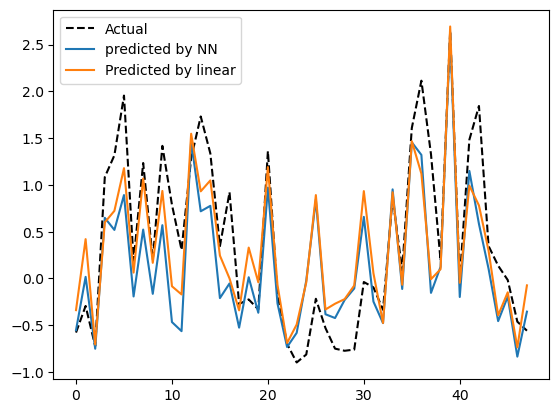

In [8]:
#better than linear regression?  No, doesn't add much skill
plt.plot(Y_test,color="k",ls="--",label="Actual")
Y_pred=model.predict(X_test)
plt.plot(Y_pred,label="predicted by NN")
from sklearn.linear_model import LinearRegression
linmod=LinearRegression()
linmod.fit(X_train, Y_train)
Y_lin=linmod.predict(X_test)
plt.plot(Y_lin,label="Predicted by linear")
plt.legend()

In [25]:
#regional
import regionmask
mask=regionmask.defined_regions.ar6.land.mask_3D(CRU.data,use_cf=False)
weights = np.cos(np.deg2rad(CRU.data.lat))
regional_data = CRU.data.weighted(mask * weights).mean(dim=("lat", "lon"))

In [9]:
def match_region_abbrev_to_number(regionabbrev):
    return regionmask.defined_regions.ar6.all.abbrevs.index(regionabbrev)
region_numbers=[match_region_abbrev_to_number(x) for x in ["NWN","NEN","WNA","CNA","ENA","NCA"]]
coarsened=regional_data.sel(region=region_numbers)


NameError: name 'regional_data' is not defined

In [ ]:
train_per=("1950-6-1","2023-8-31")
test_per=("1902-6-1","1949-8-31")
X_train=coarsened.sel(time=slice(*train_per),variable=["T","P"]).stack(regressor=("variable","region")).values
Y_train=coarsened.sel(time=slice(*train_per),variable="PDSI").values
X_test=coarsened.sel(time=slice(*test_per),variable=["T","P"]).stack(regressor=("variable","region")).values
Y_test=coarsened.sel(time=slice(*test_per),variable="PDSI")
cov_NN_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
cov_NN_model.fit(X_train,Y_train)
Y_pred=cov_NN_model.predict(X_test)
plt.plot(Y_test.values[:,3])
plt.plot(Y_pred[:,3])

In [24]:
# Global
X_train=z_train.sel(variable=["T","P"]).stack(gridvar=("lat","lon","variable")).dropna(dim="gridvar")
Y_train=z_train.sel(variable="PDSI").stack(gridcell=("
model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)


(74, 28192)

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
model.fit(X_train, Y_train)
X_test=z_test.sel(variable=["T","P"],lat=latitude,lon=longitude).values.T
Y_test=z_test.sel(variable="PDSI",lat=latitude,lon=longitude).values